# SSH variability FESOM/ICON/AVISO

In [1]:
import xarray as xr
import numpy as np
import gribscan
import intake
import eccodes
import healpy as hp
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.feature as cfeature

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
print(list(cat.IFS))

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']


In [4]:
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [5]:
ds

<xarray.Dataset>
Dimensions:        (time: 8990, value: 3145728)
Coordinates:
    lat            (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
    lon            (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2045-01-01
Dimensions without coordinates: value
Data variables:
    avg_mlotst125  (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_siconc     (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sisnthick  (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sithick    (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_siue       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sivn       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_sos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_tos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    avg_zos        (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [6]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=20, threads_per_worker=1, memory_limit='10GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38911,Workers: 20
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:45403,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/32945/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:37639,


In [8]:
# ssh_std = ds['avg_zos'].sel(time=slice('2020','2022')).std(dim='time').compute()
ssh_std = ds['avg_zos'].sel(time=slice('2020','2045')).std(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 52.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
ssh_std

<xarray.DataArray 'avg_zos' (value: 3145728)>
array([0.04745363, 0.04747203, 0.04701162, ..., 0.04916504, 0.04928353,
       0.04919951])
Coordinates:
    lat      (value) float64 0.0746 0.1492 0.1492 ... -0.1492 -0.1492 -0.0746
    lon      (value) float64 45.0 45.09 44.91 45.0 ... 315.0 315.1 314.9 315.0
Dimensions without coordinates: value

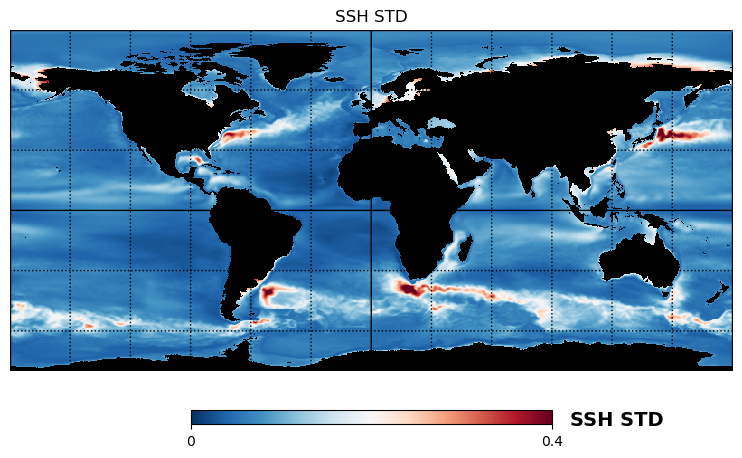

In [11]:
interpolated_data = hp.cartview(ssh_std.values,
            flip="geo", 
            nest=True, 
            rot=[0,0,],
            unit='SSH STD',
            lonra=[-180,180],
            latra=[-80, 90],
            title='SSH STD',
            min=0,
            max=0.4,
            # notext=True
            cmap =cm.RdBu_r,
            badcolor='black',
            return_projected_map=True,
        
           )
hp.graticule(dpar=30, dmer=30)

Load ICON data, note they are on different zoom level

In [12]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds_icon = cat.ICON['ngc4008'](zoom=8, chunks={'time':30,'cell':100000}).to_dask() 
# ds_icon['zos'][0,:].values

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "cell" starting at index 100000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [13]:
ds_icon

<xarray.Dataset>
Dimensions:                              (time: 4199, depth_half: 73,
                                          cell: 786432, level_full: 90, crs: 1,
                                          depth_full: 72,
                                          soil_depth_water_level: 5,
                                          level_half: 91,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 nan
  * depth_full                           (depth_full) float32 1.0 ... 5.816e+03
  * depth_half                           (depth_half) float32 0.0 ... 5.951e+03
  * level_full                           (level_full) int32 1 2 3 4 ... 88 89 90
  * level_half                           (level_half) int32 1 2 3 4 ... 89 90 91
  * soil_depth_energy_level              (soil_depth_energy_level) float32 0....
  * soil_depth_water_level               (soil_depth_water_level) float32 0.0...
  * time                                 (time) datetime64[ns] 2020-01-02 ......
Dimensions without coordinates: cell
Data variables: (12/103)
    A_tracer_v_to                        (time, depth_half, cell) float32 dask.array<chunksize=(30, 33, 100000), meta=np.ndarray>
    FrshFlux_IceSalt                     (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    FrshFlux_TotalIce                    (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    Qbot                                 (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    Qtop                                 (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    Wind_Speed_10m                       (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    ...                                   ...
    vas                                  (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    w                                    (time, depth_half, cell) float32 dask.array<chunksize=(30, 33, 100000), meta=np.ndarray>
    wa_phy                               (time, level_half, cell) float32 dask.array<chunksize=(30, 31, 100000), meta=np.ndarray>
    zg                                   (level_full, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>
    zghalf                               (level_half, cell) float32 dask.array<chunksize=(31, 100000), meta=np.ndarray>
    zos                                  (time, cell) float32 dask.array<chunksize=(30, 100000), meta=np.ndarray>

In [14]:
ssh_std_icon = ds_icon['zos'].sel(time=slice('2020','2031')).std(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

Ice is part of SSH in ICON, so don't pay atention to polar regions.

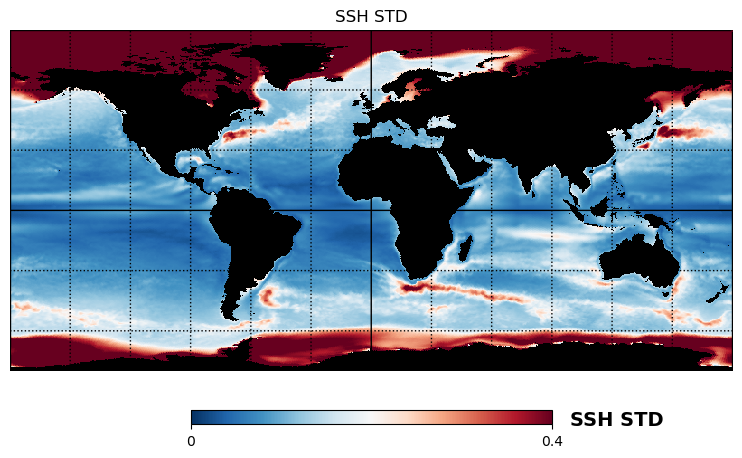

In [15]:
interpolated_data = hp.cartview(ssh_std_icon.values,
            flip="geo", 
            nest=True, 
            rot=[0,0,],
            unit='SSH STD',
            lonra=[-180,180],
            latra=[-80, 90],
            title='SSH STD',
            min=0,
            max=0.4,
            # notext=True
            cmap =cm.RdBu_r,
            badcolor='black',
            return_projected_map=True,
        
           )
hp.graticule(dpar=30, dmer=30)

As mentioned before the zoom levels of the data are different:

In [16]:
hp.npix2nside(len(ssh_std))

512

In [17]:
hp.npix2nside(len(ssh_std_icon))

256

We can change the zoom level, in this case, we increase resolution of ICON data

In [26]:
ssh_std_icon_up = hp.ud_grade(ssh_std_icon, nside_out=512, pess=False, order_in='NESTED', order_out='NESTED').astype('float32')

In [27]:
hp.npix2nside(len(ssh_std_icon_up))

512

Now we can substract things easilly

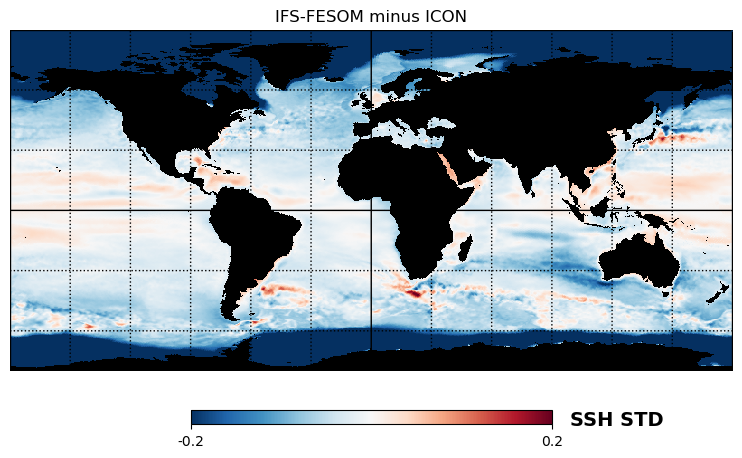

In [28]:
interpolated_data = hp.cartview(ssh_std.values-ssh_std_icon_up,
            flip="geo", 
            nest=True, 
            rot=[0,0,],
            unit='SSH STD',
            lonra=[-180,180],
            latra=[-80, 90],
            title='IFS-FESOM minus ICON',
            min=-0.2,
            max=0.2,
            # notext=True
            cmap =cm.RdBu_r,
            badcolor='black',
            return_projected_map=True,
        
           )
hp.graticule(dpar=30, dmer=30)

Now load AVISO data from EERIE catalogue

In [21]:
catO = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['observations']

In [22]:
aviso = catO['AVISO']['ssh-L4']['daily'].to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [23]:
aviso

<xarray.Dataset>
Dimensions:         (time: 10766, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-06-23
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [24]:
ssh_aviso = aviso.adt.sel(time= slice('2000', '2022')).std(dim='time').compute()

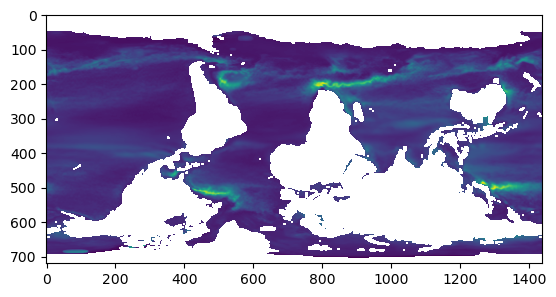

In [29]:
plt.imshow(ssh_aviso)

We are going to interpolate model data to AVISO grid:

In [30]:
lon2, lat2 = np.meshgrid(ssh_aviso.longitude.values, ssh_aviso.latitude.values)

In [31]:
pix = hp.ang2pix(
        hp.npix2nside(len(ssh_std)), theta=lon2,
                                     phi=lat2, nest=True, lonlat=True
    )

In [32]:
pix.shape

(720, 1440)

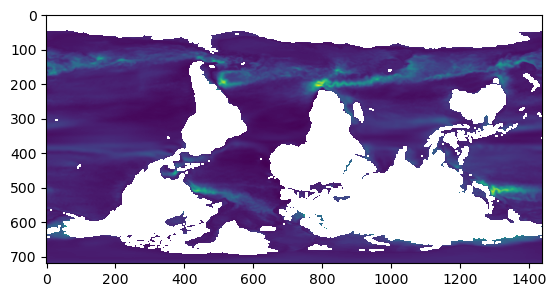

In [33]:
plt.imshow(ssh_std.values[pix])

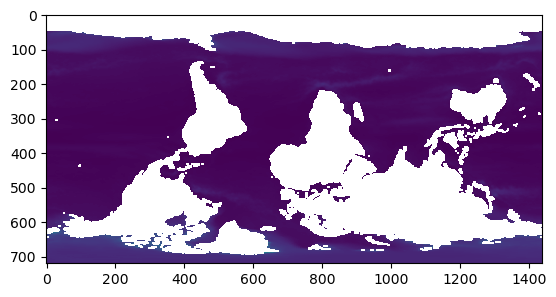

In [35]:
plt.imshow(ssh_std_icon_up[pix])

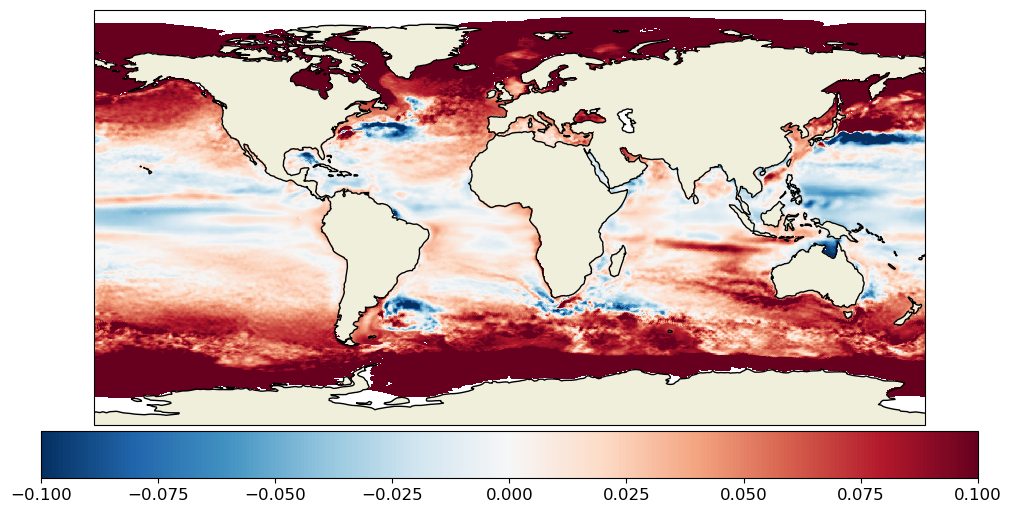

In [36]:
projection_ccrs = ccrs.PlateCarree()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.PlateCarree()),
                    constrained_layout=True,
                    figsize=(10, 5),
                )
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(ssh_std_icon_up[pix]-ssh_aviso), cmap=cm.RdBu_r,
                vmin=-0.1, vmax=0.1,
                extent=(-180, 180, -90, 90),
                interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=12)
ax.add_feature(cfeature.LAND)

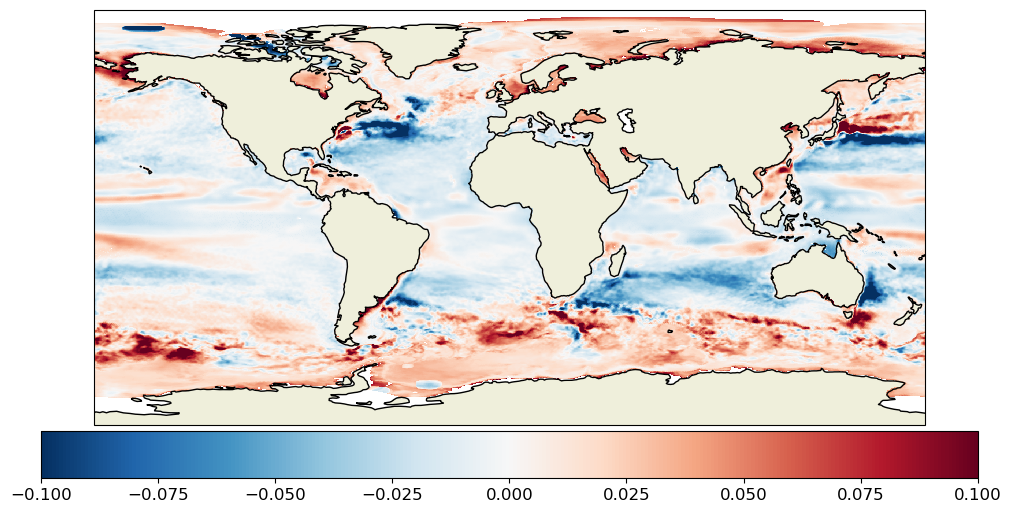

In [37]:
projection_ccrs = ccrs.PlateCarree()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.PlateCarree()),
                    constrained_layout=True,
                    figsize=(10, 5),
                )
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(ssh_std.values[pix]-ssh_aviso), cmap=cm.RdBu_r,
                vmin=-0.1, vmax=0.1,
                extent=(-180, 180, -90, 90),
                interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=12)
ax.add_feature(cfeature.LAND)

In [72]:
a = hp.get_interp_val(ssh_std.values, theta=lon2, phi=lat2, nest=True, lonlat=True)

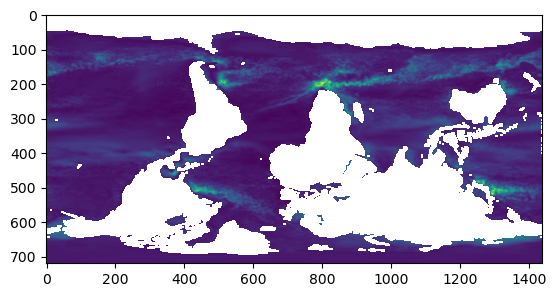

In [74]:
plt.imshow(a)